## 1. Importing dependencies

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [4]:
spark = SparkSession.builder.master("local").appName("Abalone-Spark-Test").getOrCreate()

In [5]:
spark

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=local appName=Abalone-Spark-Test>

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load The Data From a File Into a Dataframe

In [8]:
FILENAME = '../../data/raw/abalone.csv'

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [9]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("sex", StringType(), nullable=True),
    StructField("length", FloatType(), nullable=True),
    StructField("diameter", FloatType(), nullable=True),
    StructField("height", FloatType(), nullable=True),
    StructField("whole_weight", FloatType(), nullable=True),
    StructField("shucked_weight", FloatType(), nullable=True),
    StructField("viscera_weight", FloatType(), nullable=True),
    StructField("shell_weight", FloatType(), nullable=True),
    StructField("rings", IntegerType(), nullable=True)]
)

In [10]:
# Load housing data
abalone_df = spark.read.csv(path=FILENAME, schema=schema, header=True).cache()

In [11]:
# Show first five rows
abalone_df.show(5)

+---+------+--------+------+------------+--------------+--------------+------------+-----+
|sex|length|diameter|height|whole_weight|shucked_weight|viscera_weight|shell_weight|rings|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
|  M| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|   15|
|  M|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|
|  F|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9|
|  M|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|
|  I|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|    7|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
only showing top 5 rows



In [12]:
# show the dataframe columns
abalone_df.columns

['sex',
 'length',
 'diameter',
 'height',
 'whole_weight',
 'shucked_weight',
 'viscera_weight',
 'shell_weight',
 'rings']

In [13]:
# show the schema of the dataframe
abalone_df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- length: float (nullable = true)
 |-- diameter: float (nullable = true)
 |-- height: float (nullable = true)
 |-- whole_weight: float (nullable = true)
 |-- shucked_weight: float (nullable = true)
 |-- viscera_weight: float (nullable = true)
 |-- shell_weight: float (nullable = true)
 |-- rings: integer (nullable = true)



## 4. Data Exploration

In [14]:
(abalone_df.describe().select(
                    "summary",
                    F.round("length", 4).alias("length"),
                    F.round("diameter", 4).alias("diameter"),
                    F.round("height", 4).alias("height"),
                    F.round("whole_weight", 4).alias("whole_weight"),
                    F.round("shucked_weight", 4).alias("shucked_weight"),
                    F.round("viscera_weight", 4).alias("viscera_weight"),
                    F.round("shell_weight", 4).alias("shell_weight"),
                    F.round("rings", 4).alias("rings"),
                    ).show())

+-------+------+--------+------+------------+--------------+--------------+------------+------+
|summary|length|diameter|height|whole_weight|shucked_weight|viscera_weight|shell_weight| rings|
+-------+------+--------+------+------------+--------------+--------------+------------+------+
|  count|4177.0|  4177.0|4177.0|      4177.0|        4177.0|        4177.0|      4177.0|4177.0|
|   mean| 0.524|  0.4079|0.1395|      0.8287|        0.3594|        0.1806|      0.2388|9.9337|
| stddev|0.1201|  0.0992|0.0418|      0.4904|         0.222|        0.1096|      0.1392|3.2242|
|    min| 0.075|   0.055|   0.0|       0.002|         0.001|        5.0E-4|      0.0015|   1.0|
|    max| 0.815|    0.65|  1.13|      2.8255|         1.488|          0.76|       1.005|  29.0|
+-------+------+--------+------+------------+--------------+--------------+------------+------+



Text(0.5, 1.0, 'sex')

<AxesSubplot:title={'center':'sex'}>

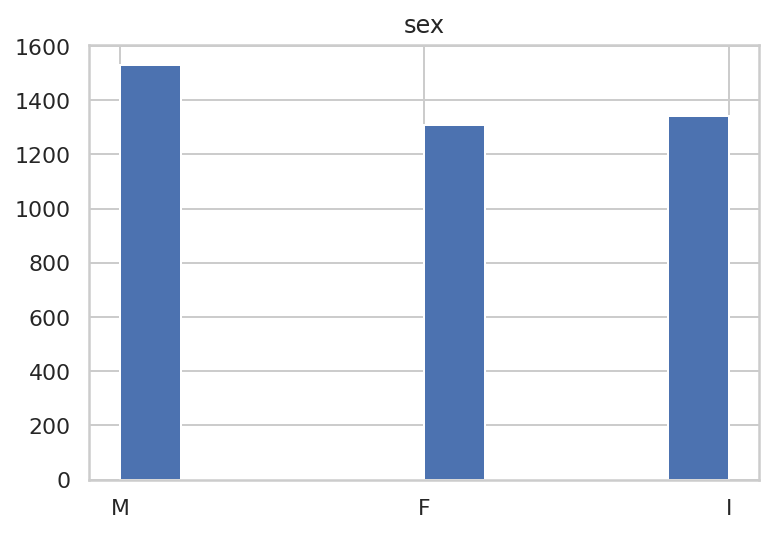

Text(0.5, 1.0, 'length')

<AxesSubplot:title={'center':'length'}>

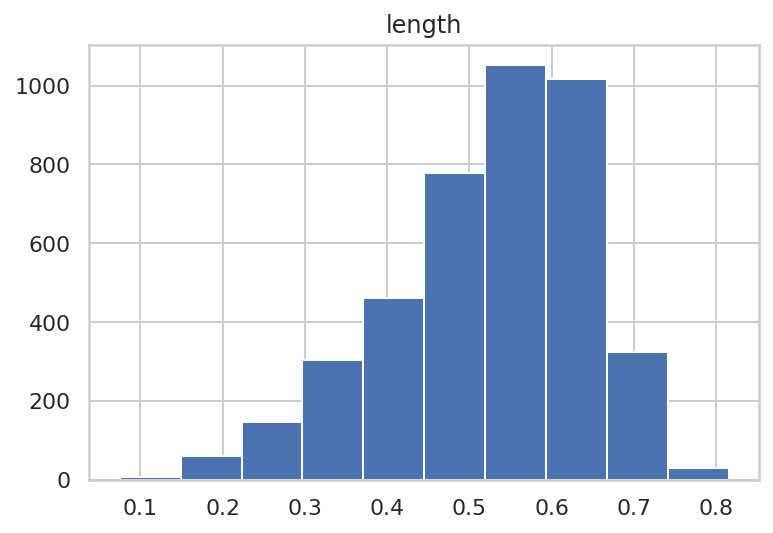

Text(0.5, 1.0, 'diameter')

<AxesSubplot:title={'center':'diameter'}>

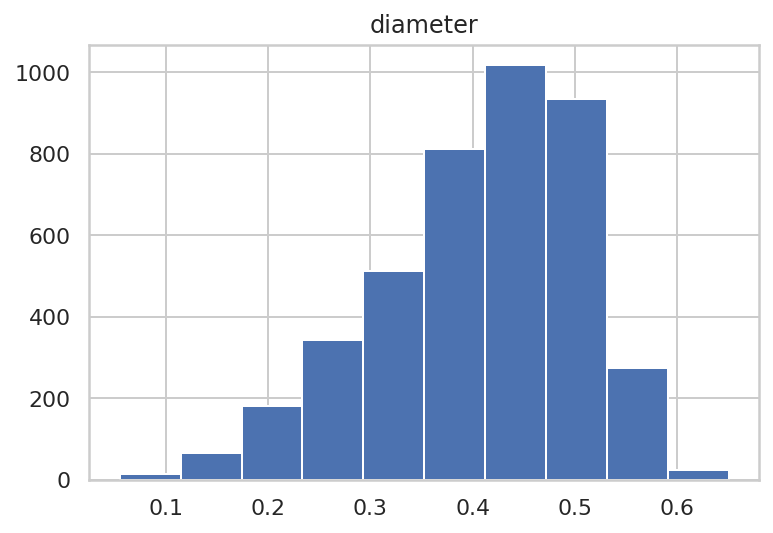

Text(0.5, 1.0, 'height')

<AxesSubplot:title={'center':'height'}>

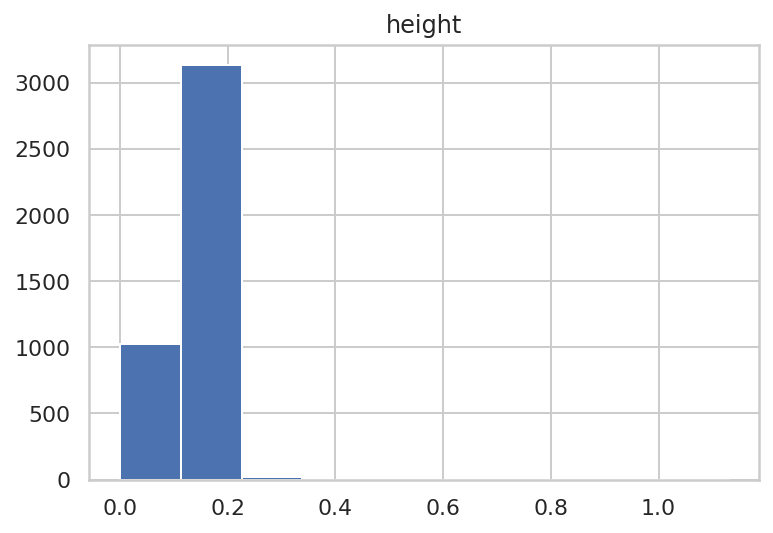

Text(0.5, 1.0, 'whole_weight')

<AxesSubplot:title={'center':'whole_weight'}>

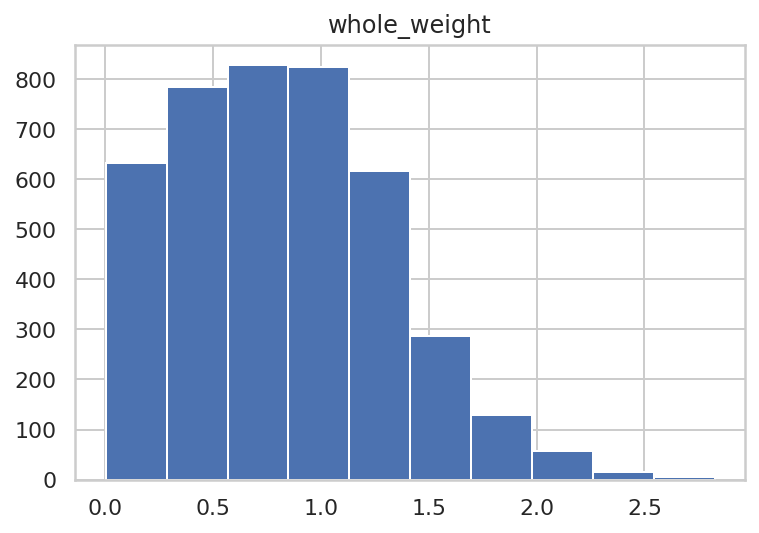

Text(0.5, 1.0, 'shucked_weight')

<AxesSubplot:title={'center':'shucked_weight'}>

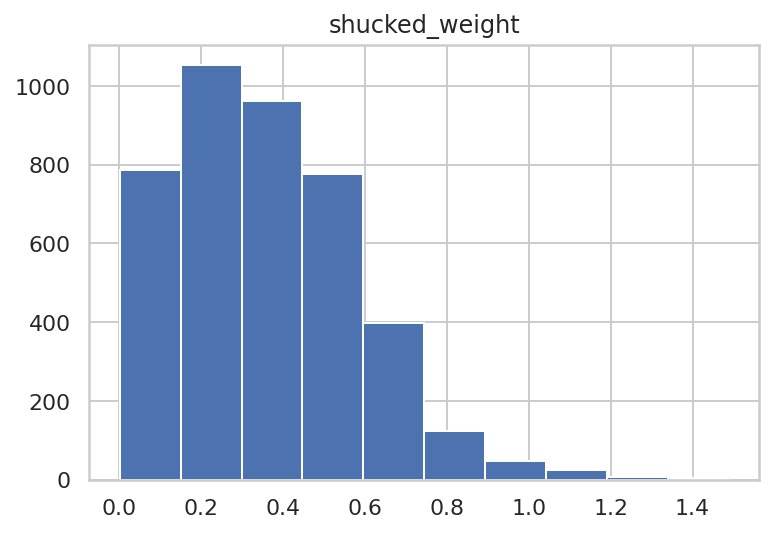

Text(0.5, 1.0, 'viscera_weight')

<AxesSubplot:title={'center':'viscera_weight'}>

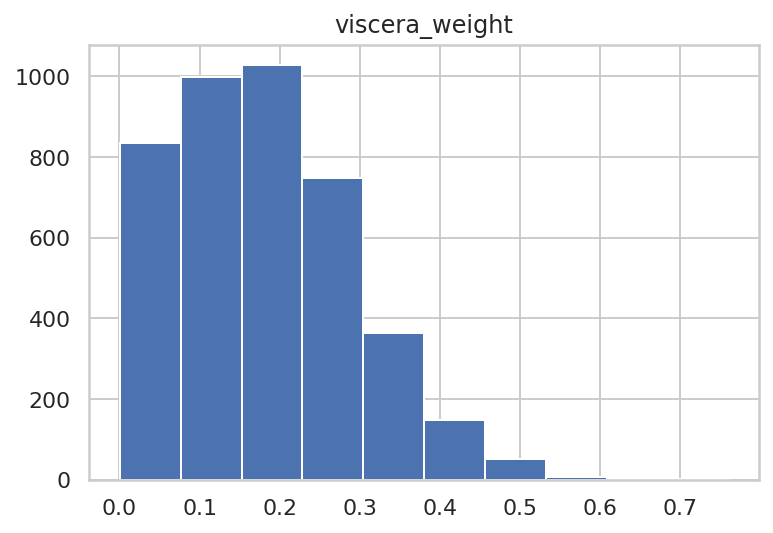

Text(0.5, 1.0, 'shell_weight')

<AxesSubplot:title={'center':'shell_weight'}>

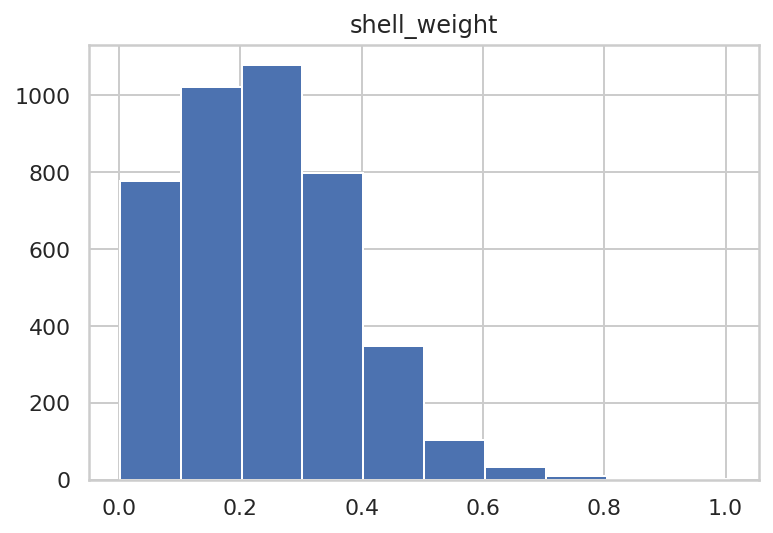

Text(0.5, 1.0, 'rings')

<AxesSubplot:title={'center':'rings'}>

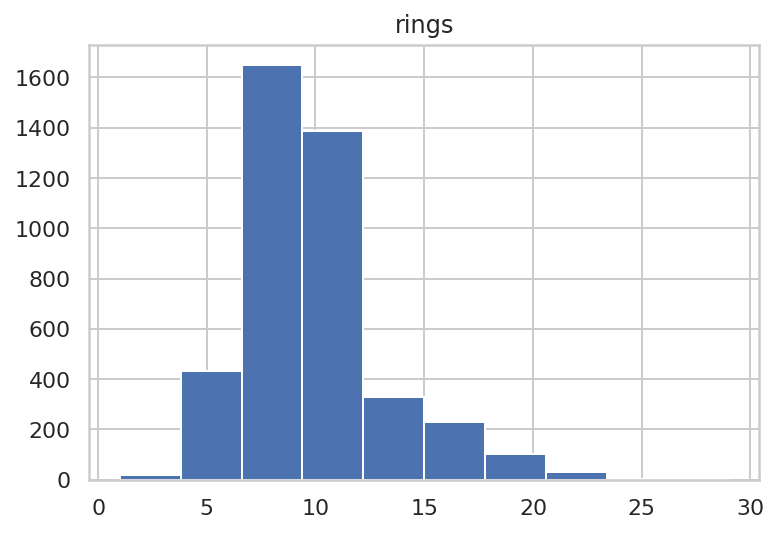

In [15]:
df_pandas =  abalone_df.toPandas()
for col in abalone_df.columns:
    plt.title(col)
    df_pandas[col].hist(figsize=(6, 4))
    plt.show()

## 5. Data Preprocessing


## 6. Feature Engineering


In [16]:
featureCols = ['length', 'diameter', 'height','whole_weight',
               'shucked_weight','viscera_weight','shell_weight']
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(abalone_df)

In [17]:
assembled_df.show(10, truncate=False)

+---+------+--------+------+------------+--------------+--------------+------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------+
|sex|length|diameter|height|whole_weight|shucked_weight|viscera_weight|shell_weight|rings|features                                                                                                                                      |
+---+------+--------+------+------------+--------------+--------------+------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------+
|M  |0.455 |0.365   |0.095 |0.514       |0.2245        |0.101         |0.15        |15   |[0.45500001311302185,0.36500000953674316,0.0949999988079071,0.5139999985694885,0.22450000047683716,0.10100000351667404,0.15000000596046448]   |
|M  |0.35  |0.265   |0.09  |0.2255      |0.0995        |0.0485  

In [18]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [19]:
# Fit the DataFrame to the scaler
prep_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [20]:
# Inspect the result
prep_df.select("features", "features_scaled").show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                      |features_scaled                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|[0.45500001311302185,0.36500000953674316,0.0949999988079071,0.5139999985694885,0.22450000047683716,0.10100000351667404,0.15000000596046448]   |[3.7887

### 7. Building A Machine Learning Model With Spark ML



In [21]:
# Split the data into train and test sets
train_data, test_data = prep_df.randomSplit([.8,.2], seed=rnd_seed)

In [22]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="rings", predictionCol='predrings',
                       maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [23]:
# Fit the data to the model
linearModel = lr.fit(train_data)

## 8. Evaluating the Model



In [24]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.078, 0.8356, 0.0, -0.104, 0.0, 1.1197])

In [25]:
featureCols

['length',
 'diameter',
 'height',
 'whole_weight',
 'shucked_weight',
 'viscera_weight',
 'shell_weight']

In [26]:
# Intercept for the model
linearModel.intercept

5.084211235021854

In [27]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [28]:
coeff_df

,Feature,Co-efficients
0,Intercept,5.084211
1,length,0.000000
2,diameter,0.078039
3,height,0.835615
4,whole_weight,0.000000
5,shucked_weight,-0.104036
6,viscera_weight,0.000000
7,shell_weight,1.119691


In [29]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [30]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predrings", "rings")

In [31]:
predandlabels.show()

+-----------------+-----+
|        predrings|rings|
+-----------------+-----+
|7.665683469721766|   10|
|7.538301916407348|    7|
|7.127155265699342|   10|
| 7.89814505123021|    8|
|7.931010305130178|    7|
|8.801059328560532|    7|
|7.909133065023619|    6|
|8.143703808822831|   10|
|8.138808469801239|   12|
|8.335259126453778|   16|
| 8.27191841248612|    8|
| 8.35417708347964|   12|
|8.704584948681825|    8|
|8.435583761487715|   11|
|8.806159518778927|    7|
|8.495427691295493|   13|
|8.712457464876632|   11|
|8.922651897950075|   10|
| 9.34827132849762|    9|
|8.411504270734717|    6|
+-----------------+-----+
only showing top 20 rows



In [32]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 2.5306892133884586


In [33]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 1.826166767598649


In [34]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.40422983459696027


In [35]:
spark.stop()